# Set up

In [26]:
# install.packages("corrplot")
# install.packages("car")
# install.packages("stargazer")
# install.packages("sandwich")

library(car)
library(corrplot)
library(stargazer)
library(sandwich)

# Introduction

The great state of North Carolina and its 100 counties make for a diverse place, with both urban and rural, richer and poorer areas. The state has been significant historically with rich culture and importance going back to the American civil war. Today, the state capital of Raleigh is a thriving research-based region, while the city of Charlotte is the 2nd largest Banking center in the US after New York. However, there are obvious concerns related to violence and crime statistics. With the upcoming elections in most of the 13 congressional districts of the state, our agency has been hired to provide a detailed research on crime rates in the state and how best to provide an actionable set of policy recommendations -- so that the candidate could lay those out to the election going public and hopefully also sway indepenedents in their favor.  

# Research question

This particular project aims to determine whether economic prosperity helps in reducing crime. It is commonly known that crime tends to correlate with factors such as higher population density and urban areas; however, there has been less research on the effect of wages on an area's crime rate.

Therefore, we summarize our research question as: **does economic prosperity and wages help in reducing crime?**

Based on the results of this analysis, we aim to recommend whether our political compaign should advocate for additional policy changes based on economic prosperity to reduce crime or whether efforts at reducing crime should be placed elsewhere. Note that whether or not economic prosperity has an effect on crime, it continues to be a worthy goal with many potential positive effects in other parts of our constituents lives; additional research will be required to determine the effects on other aspects of quality-of-life.

# Methodology and EDA

We use data from C. Cornwell and W. Trumball (1994), “Estimating the Economic Model of Crime with Panel Data,” Review of Economics and Statistics 76, 360-366.

We start with initial data cleaning by removing blank rows, converting quantitative columns to numeric values, and dropping constant features (year). 

In [27]:
data <- read.table("crime_v2.csv", header=TRUE, sep=",")
data <- na.omit(data, cols="county")  # Remove empty rows read into bottom of table
data$prbconv <- as.numeric(data$prbconv)  # Convert factor column to numeric
data = subset(data, select=-c(year))  # Drop column column with only 1 unique value
summary(data)

     county          crmrte             prbarr           prbconv     
 Min.   :  1.0   Min.   :0.005533   Min.   :0.09277   Min.   : 3.00  
 1st Qu.: 52.0   1st Qu.:0.020927   1st Qu.:0.20568   1st Qu.:25.50  
 Median :105.0   Median :0.029986   Median :0.27095   Median :48.00  
 Mean   :101.6   Mean   :0.033400   Mean   :0.29492   Mean   :47.75  
 3rd Qu.:152.0   3rd Qu.:0.039642   3rd Qu.:0.34438   3rd Qu.:70.00  
 Max.   :197.0   Max.   :0.098966   Max.   :1.09091   Max.   :92.00  
    prbpris           avgsen           polpc              density       
 Min.   :0.1500   Min.   : 5.380   Min.   :0.0007459   Min.   :0.00002  
 1st Qu.:0.3648   1st Qu.: 7.340   1st Qu.:0.0012308   1st Qu.:0.54741  
 Median :0.4234   Median : 9.100   Median :0.0014853   Median :0.96226  
 Mean   :0.4108   Mean   : 9.647   Mean   :0.0017022   Mean   :1.42884  
 3rd Qu.:0.4568   3rd Qu.:11.420   3rd Qu.:0.0018768   3rd Qu.:1.56824  
 Max.   :0.6000   Max.   :20.700   Max.   :0.0090543   Max.   :8.82765  

A view of the data summary provides some information on the distribution of each row, allowing us to notice that there is an outlier in the average weekly wages of the services industry `wser` column. This outlier has weekly wages 10X the average wage. Because the difference is so large, even compared to wage differences in any other industries, we conclude that this outlier was likely due to a data entry error. Thus we decide to remove this datapoint. 

In [28]:
data <- data[(data$wser<1000),]

Because we're interested in the economic determinants of crime, we have decided to define the average number of crimes per person `crmrte` as our endogenous variable that we will regress.

Next, we look at the correlations between our variables (below) to look for potentially informative features as well as multi-collinearity. Even though there are a number of variables that are correlated with each other (e.g., all of the wage variables), we do not see any perfect multi-collinearity in the correlation matrix.

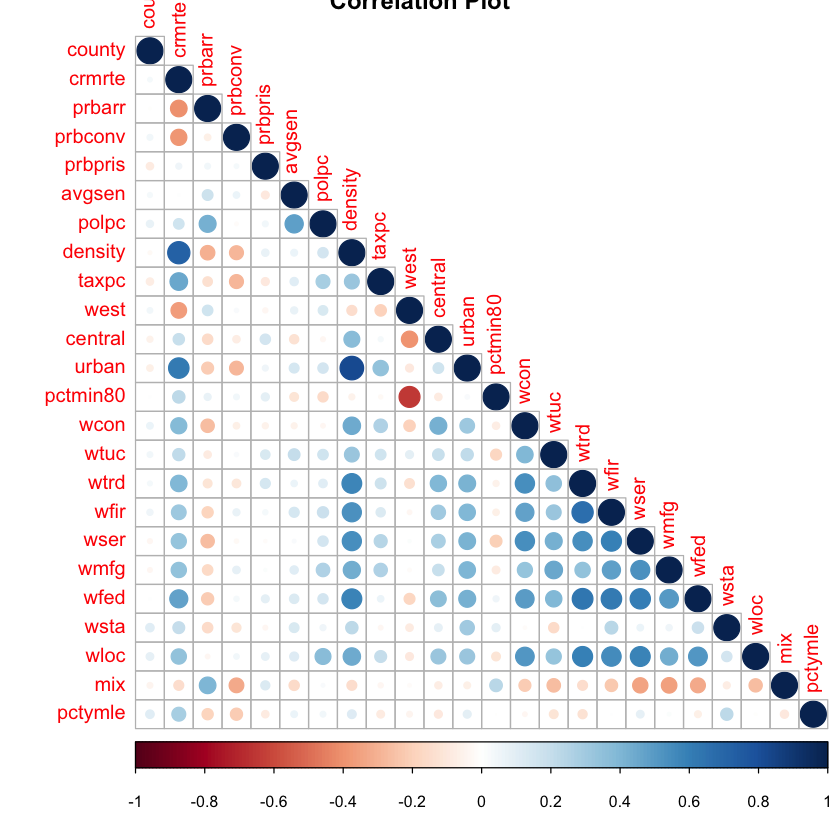

In [29]:
correlations <- cor(data)
corrplot(correlations, type="lower", method='circle', main="Correlation Plot")

We do see that the following variables are most correlated with crime rate: 
* wage related variables: `wcon`, `wtuc`, `wtrd`, `wfir`, `wser`, `wmfg`, `wfed`, `wsta`, `wloc`
* population density variables
* police presence and conviction variables

We aim to regress crime rate, `crmrte`, to wage related variables acting as a proxy for economic prosperity (`wcon`, `wtuc`, `wtrd`, `wfir`, `wser`, `wmfg`, `wfed`, `wsta`, `wloc`). Each of the wage variables indicates the average weekly wage for employees in a particular industry. 

--------------------

Our first model will only look at crime rate regressed on the wage related variables. However, as this does not take into account of important latent variables that also have a strong impact on crime (e.g., population density, police presence), we build a second model with both wage variables and key co-variates included. This way, we are able to isolate the effect of wages on crime without the interference of some of the key latent variables.

Lastly, we create a larger model with all of the main variables included to further isolate the effect of wages on crime. After each model, we will discuss the potential effects of omitted latent variables that we either have not yet included into the model or do not have data for.

Note that for our non-wage-related variables, we transform them (e.g., log, sqrt) as necessary to optimize the strength of their relationship with crime rate. Even though, it reduces the explainability of the non-wage-related variables, our key focus is on the effect of wages on crime anyway. By controlling as much as possible for the effect of other variables (by optimally transforming them to have a strong linear relationship with crime rate), we can focus more on the incremental impact of wages on crime. In other words, we are controlling for otherwise omitted latent relationships (e.g., non-linear) from other variables that may be affecting our wage variables.

While the wage related variables may also have non-linear relationships, we do not transform these to maximize interpretability of our models.

--------------------

Note that we've chosen to exclude the following columns:
* `urban`
* `county`
* `mix`

We exclude `urban` because it is defined as basically a calculated variable from `density` (based on the definition given in Cornwell & Trumball). We exclude county because it is an identifier column and not a characteristic. And lastly, we exclude `mix` because it is a descriptor of types of crime and thus not a possible causal variable of crime itself.

# Model 1 

We first take a look at the distribution of each of our variables. They all look roughly normal although there is some light right skew (e.g., `crmrte`, `wtrd`, `wmfg`)

For greater interpretability, we decided not to transform these key endogenous/exogenous variables that we are most interested in.

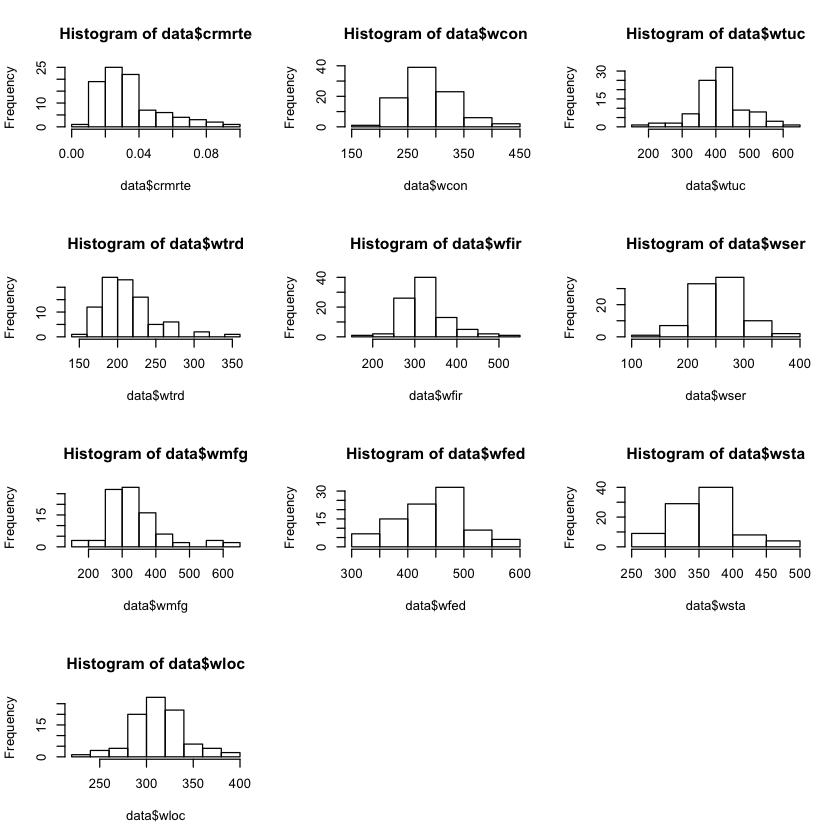

In [30]:
par(mfrow=c(4,3))
hist(data$crmrte)
hist(data$wcon)
hist(data$wtuc)
hist(data$wtrd)
hist(data$wfir)
hist(data$wser)
hist(data$wmfg)
hist(data$wfed)
hist(data$wsta)
hist(data$wloc)

Our first model regresses crime rate on the average weekly wage of different industries. We see that these variables are able to explain about 23% of the variability in the crime rate (based on adjusted R2). 

`wtrd`, the wage of the retail industry, has the largest coefficient of 0.0001155, indicating that every \$1000 increase in weekly retail wages could be associated with an 0.12 increase in average crimes per person. On the other hand, `wfir`, the weekly wage of the finance / insurance / real estate industries, has the most negative coefficient of -0.0000642, indicating that every \$1000 increase in weekly finance / insurance / real estate wages could be associated with a 0.06 decrease in average crimes per person. However, rather than jumping to conclusions on the effect of wages to crime, we realize that this initial baseline model has many different omitted latent variables that could be affecting the results of our analysis. 

In [31]:
model = lm(crmrte ~ wcon + wtuc + wtrd + wfir + wser + wmfg + wfed + wsta + wloc, data=data)
model_summary = summary(model)
paste('Adjusted R-Squared is', model_summary$adj.r.squared)
model_summary

[1] "Adjusted R-Squared is 0.233537604132852"


Call:
lm(formula = crmrte ~ wcon + wtuc + wtrd + wfir + wser + wmfg + 
    wfed + wsta + wloc, data = data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.034999 -0.009483 -0.003980  0.006028  0.052221 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept) -6.743e-02  2.396e-02  -2.815  0.00615 **
wcon         7.378e-05  4.868e-05   1.516  0.13355   
wtuc        -2.790e-06  2.753e-05  -0.101  0.91954   
wtrd         1.155e-04  8.243e-05   1.402  0.16492   
wfir        -6.419e-05  5.112e-05  -1.256  0.21288   
wser        -1.270e-05  5.922e-05  -0.215  0.83070   
wmfg         3.674e-05  2.610e-05   1.408  0.16300   
wfed         8.209e-05  4.475e-05   1.834  0.07032 . 
wsta         8.348e-05  4.519e-05   1.847  0.06841 . 
wloc         6.292e-06  8.646e-05   0.073  0.94217   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01643 on 80 degrees of freedom
Multiple R-squared:  0.311,	Adjusted R-squ

Some of the major omitted variables that we believe could have a significant impact on crime rates include the population density and the police presence within an area. 

As seen in the scatter plot below, population density is most likely positively correlated with both crime rate as well as wages (as wages tend to be higher in cities, which have higher population densities); we also see this in the calculated correlation. Because the omitted population density variable is positively correlated with both our endogenous and included exogenous variables, it is likely artificially increasing the modeled effect of the included exogenous variables. Said another way, because positive effect of population density on crime is not included, it is partially included in the wage variables, causing the coefficients/effect of the wage variables on crime to be more positive than they may be in reality.

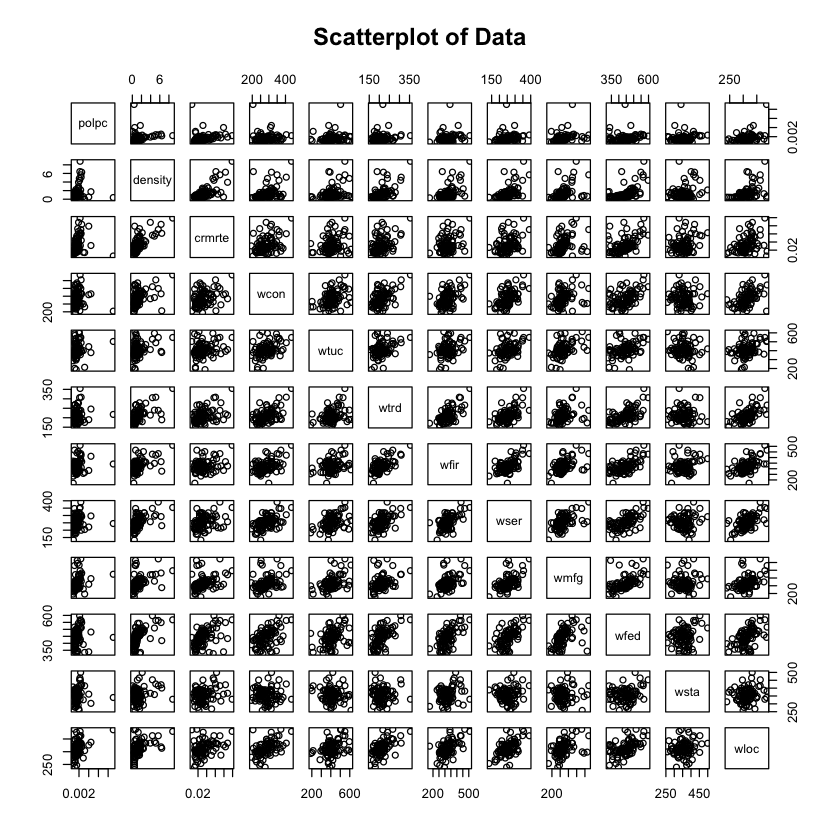

In [32]:
pairs(~polpc + density + crmrte + wcon + wtuc + wtrd + wfir + wser + wmfg + wfed + wsta + wloc,data=data,
   main="Scatterplot of Data")

There are a number of variables omitted from our first model that may have a big effect, including:
* GDP (per-capita growth)
* Drug use and addiction
* Strength of education system (pct with college degrees)
* Strength of education system (special ed)
* Strength of education system (K-12)
* Households with single parent
* Housing prices
* Employment rate
* Religion (pct people identifying as religious/spiritual)
* Physical environment (natural disasters rate / temperature / weather)
* Government funding for social welfare
* Population growth
* Job growth
* Cost of living

In order to control for some of the effects of the omitted variables, we next create a second model with our model-1 coefficients in addition to:
* `taxpc`
* `polpc`
* `density`
* `pctymle`
* `prbarr`

Therefore: `Model 2 = Model 1 + taxpc, density, pctymle, polpc, prbarr`

# Model 2

In our second model, we are looking for non-wage variables that may be able to explain as much of the variation in crime rate as possible so that we can focus on the incremental effect of wage variables.

Thus, while we have decided to transform our dependent variable or the wage related variables for explainability, we're comfortable transforming any of the other variables in any way that can lead to a better fit for our model.

We create a correlation matrix of our non-wage variables (linear and transformed) with crime rate to help us assess whether to use the original linear variables in our subsequent models or to use the corresponding transformed variables. For each non-wage variable, we'll choose the transformation that has the highest correlation with crime rate.

In [33]:
linear = cor(data.frame(data, data$crmrte))[,25]
logarithm = cor(data.frame(log(data), data$crmrte))[,25]
square_root = cor(data.frame(sqrt(data), data$crmrte))[,25]
square = cor(data.frame(data^2, data$crmrte))[,25]

df1 = data.frame(linear, logarithm, square_root, square)
df1[c(3:13, 23:24),]

,linear,logarithm,square_root,square
prbarr,-0.407623882,-0.43603457,-0.42891421,-0.33018870
prbconv,-0.384734631,-0.30796639,-0.35764853,-0.40294654
prbpris,0.052840613,0.09037005,0.07152836,0.01825894
avgsen,0.007397583,0.05419136,0.03161315,-0.04259903
polpc,0.164891574,0.38662275,0.28644420,-0.03142815
density,0.727522933,0.47403654,0.73040522,0.66086033
taxpc,0.457646315,0.42502877,0.44568208,0.44584684
west,-0.360758914,NaN,-0.36075891,-0.36075891
central,0.190233555,NaN,0.19023356,0.19023356
urban,0.616765513,NaN,0.61676551,0.61676551


A scatterplot matrix of crime rate with the non-wage variables before and after transformations shows that the transformed variables both seem to be more normally distributed and have a more linear relationship with crime rate.

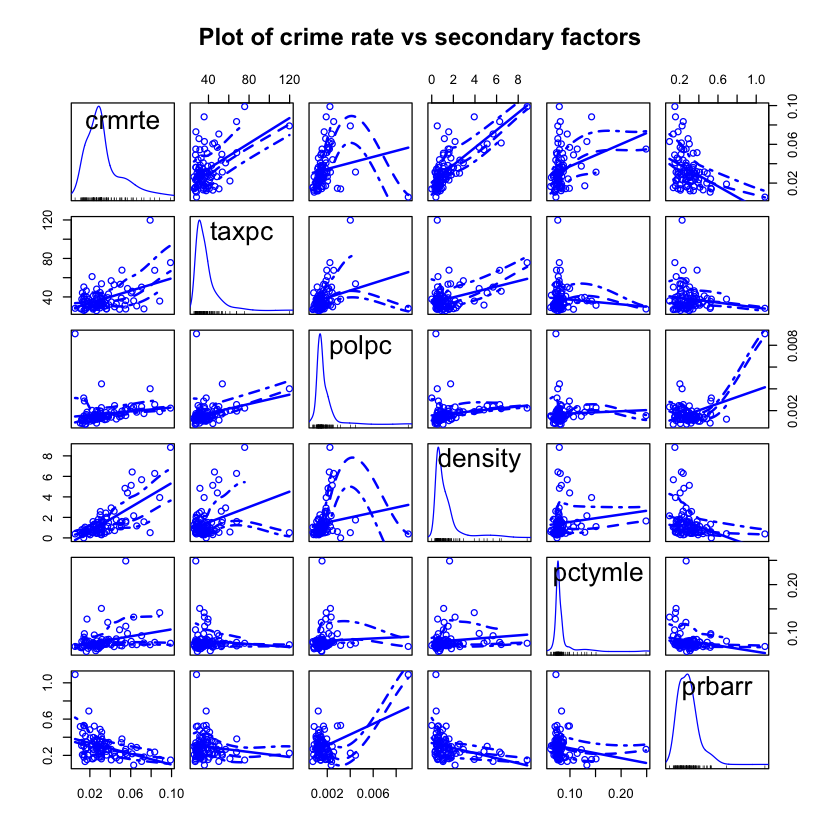

In [34]:
library(car)
scatterplotMatrix(~crmrte + taxpc + polpc + density + pctymle + prbarr, data=data,
                   main="Plot of crime rate vs secondary factors")

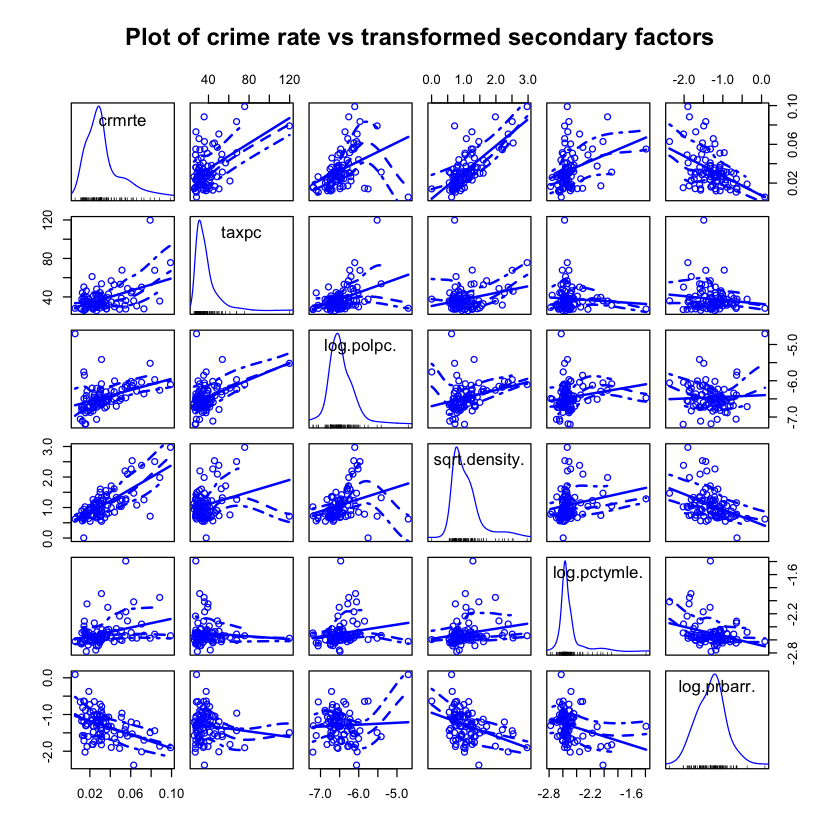

In [35]:
scatterplotMatrix(~crmrte + taxpc + log(polpc) + sqrt(density) + log(pctymle) + log(prbarr) , data=data,
                   main="Plot of crime rate vs transformed secondary factors")

We revise the definition of our 2nd model as follows:

`Model 2 = Model 1 + taxpc, sqrt(density), log(pctymle), log(polpc), log(prbarr)`

------------------------------------------------


First we will start out by creating a model where every variable is untransformed.

In [36]:
secondary_model = lm(crmrte ~ wcon + wtuc + wtrd + wfir + wser + wmfg + 
                     wfed + wsta + wloc + taxpc + density + pctymle + 
                     polpc + prbarr, data=data)
secondary_model_summary = summary(secondary_model)
c('Adjusted R-Squared is', secondary_model_summary$adj.r.squared)
secondary_model_summary

[1] "Adjusted R-Squared is" "0.693138321505037"


Call:
lm(formula = crmrte ~ wcon + wtuc + wtrd + wfir + wser + wmfg + 
    wfed + wsta + wloc + taxpc + density + pctymle + polpc + 
    prbarr, data = data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.024724 -0.004991 -0.000171  0.005016  0.033769 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.318e-02  2.003e-02  -1.157  0.25080    
wcon         1.540e-05  3.313e-05   0.465  0.64343    
wtuc        -5.951e-07  1.759e-05  -0.034  0.97311    
wtrd         4.091e-05  5.540e-05   0.739  0.46247    
wfir        -5.561e-05  3.267e-05  -1.702  0.09286 .  
wser        -1.203e-04  3.903e-05  -3.083  0.00287 ** 
wmfg        -1.402e-06  1.702e-05  -0.082  0.93458    
wfed         9.740e-05  3.045e-05   3.198  0.00202 ** 
wsta        -1.879e-06  2.998e-05  -0.063  0.95020    
wloc         4.073e-05  5.975e-05   0.682  0.49756    
taxpc        4.414e-04  1.044e-04   4.226 6.63e-05 ***
density      6.105e-03  1.084e-03   5.632 2.95e-07 *

We then apply the best correlations from the correlation table and adjust the secondary variables.

In [37]:
secondary_model = lm(crmrte ~ wcon + wtuc + wtrd + wfir + wser + 
                     wmfg + wfed + wsta + wloc + taxpc + sqrt(density) + 
                     log(pctymle) + log(polpc) + log(prbarr), data=data)
secondary_model_summary = summary(secondary_model)
c('Adjusted R-Squared is', secondary_model_summary$adj.r.squared)
secondary_model_summary

[1] "Adjusted R-Squared is" "0.696623968204726"


Call:
lm(formula = crmrte ~ wcon + wtuc + wtrd + wfir + wser + wmfg + 
    wfed + wsta + wloc + taxpc + sqrt(density) + log(pctymle) + 
    log(polpc) + log(prbarr), data = data)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0239501 -0.0052841  0.0004469  0.0050843  0.0293214 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    7.004e-02  3.544e-02   1.976  0.05181 .  
wcon           2.393e-05  3.246e-05   0.737  0.46340    
wtuc          -4.557e-06  1.749e-05  -0.261  0.79514    
wtrd           5.604e-05  5.487e-05   1.021  0.31045    
wfir          -5.474e-05  3.242e-05  -1.688  0.09548 .  
wser          -1.310e-04  3.898e-05  -3.360  0.00123 ** 
wmfg          -3.629e-06  1.692e-05  -0.214  0.83079    
wfed           7.140e-05  3.151e-05   2.266  0.02636 *  
wsta          -1.233e-08  3.004e-05   0.000  0.99967    
wloc           2.151e-05  5.703e-05   0.377  0.70715    
taxpc          4.572e-04  1.060e-04   4.313 4.85e-05 *

After adding secondary (transformed & non transformed) variables, we do see that the overall impact of wage-related economic variables has gone down. We see that the variables most correlated with crime rates are now `pctymle`, `log(polpc)` and `log(prbarr)`. The square root of `pctymle` is highly correlated to crime rate with a p-value of 0.00162, indicating that an increase in `pctymle` leads to an increase in crime rate.

# Model 3

Lastly, we will turn to the following remaining variables to create a final model with additional features that we believe might affect crime rate, even if we believe the effect may be minimal: 
* `pctmin80`
* `prbconv`
* `prbpris`
* `avgsen`
* `west`
* `central`

Our final model is: 
`Model 3 = Model 2 + pctmin80, prbconv, prbpris, avgsen, west, central`

In [38]:
tertiary_model = lm(crmrte ~ wcon + wtuc + wtrd + wfir + wser + wmfg + wfed + wsta + wloc 
                    + taxpc + sqrt(density) + sqrt(pctymle) + log(polpc) + log(prbarr) + log(pctmin80) +
                    log(prbpris) + prbconv^2 + log(avgsen) + west + central , data=data)
tertiary_model_summary = summary(tertiary_model)
paste('Adjusted R-Squared is', tertiary_model_summary$adj.r.squared)
tertiary_model_summary

[1] "Adjusted R-Squared is 0.804983761963971"


Call:
lm(formula = crmrte ~ wcon + wtuc + wtrd + wfir + wser + wmfg + 
    wfed + wsta + wloc + taxpc + sqrt(density) + sqrt(pctymle) + 
    log(polpc) + log(prbarr) + log(pctmin80) + log(prbpris) + 
    prbconv^2 + log(avgsen) + west + central, data = data)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0203658 -0.0044360  0.0000262  0.0036173  0.0219305 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    4.390e-02  3.745e-02   1.172 0.245128    
wcon           3.120e-05  2.723e-05   1.146 0.255917    
wtuc           1.479e-05  1.502e-05   0.984 0.328407    
wtrd           4.374e-05  4.549e-05   0.962 0.339596    
wfir          -3.087e-05  2.708e-05  -1.140 0.258225    
wser          -1.163e-04  3.246e-05  -3.581 0.000632 ***
wmfg           2.243e-06  1.378e-05   0.163 0.871206    
wfed           4.331e-05  2.683e-05   1.614 0.111021    
wsta          -1.367e-06  2.484e-05  -0.055 0.956260    
wloc           3.589e-05  4.708

By including additional explanatory variables, we see that most of our wage variables now have only a negigible effect, with the majority of the variation described by taxpc, density, pctmle, polpc, prbarr, pctmin80, prbconv, avgsen, and central.

Interesting, we do notice that `wser` seems to have a significant, though small, negative effect on crime rate. In particular, every \$1000 increase in average wages in the services industry reduces crime by 0.12 crimes per person. 

In [39]:
# We can try to combine the west and central columns into a Region column that includes 0 for neither (East), 1 for Central, and 2 for West. There is one country that is labeled as both west and central, so we will include as 1.5 for this test.

# data$Region = 2 * data$west + data$central
# data$Region[data$Region==3] <- 1.5
# tertiary_model = lm(crmrte ~ wcon + wtuc + wtrd + wfir + wser + wmfg + wfed + wsta + wloc + 
#                     taxpc + sqrt(density) + sqrt(pctymle) +  log(polpc) + log(prbarr) + log(pctmin80) + 
#                     log(prbpris) + prbconv^2 + log(avgsen) + Region , data=data)
# tertiary_model_summary = summary(tertiary_model)
# paste('Adjusted R-Squared is', tertiary_model_summary$adj.r.squared)
# tertiary_model_summary

# We can see that including Region does not help the R-squared value, so we will keep it the Central and Western columns separate.

# scatterplotMatrix(~crmrte + log(pctmin80) + prbconv^2 + log(prbpris) + log(avgsen) + west + central, data=data,
#                    main="Plot of crime rate vs tertiary factors")

# correlations <- cor(data)
# correlations[order(correlations[,2]),2]

# Conclusion and recommendations

Given our various model runs and correlation analyses of `crmrte` with respect to various transformed and non-transformed variables, and in light of our initial research question ("whether economic prosperity helps in reducing crime?"), we cannot formally conclude that wage-related economic determinants are helpful in reducing crime in North Carolina. `wser` (wages in the services sector) seems to be the only exception in the wage-variables with a very low p-value of 0.00166, indicating high significance of its coefficient. However, the small value of its beta leads us to believe that the overall impact of `wser` on `crmrte` is still miniscule compared to other secondary and tertiary variables.

We do see, however, that metrics such as `taxpc`, `polpc`, `density` have low p-values and high correlation components with `crmrte`. We do not state that these variables have a causal impact on crime statistics in the state -- and believe that `crmrte` could also be possibly correlated with latent variables outlined in our text above. 

In [53]:
stargazer(model, secondary_model, tertiary_model, type = "text", 
          digits=5, omit.stat = c("f","ser"))


                      Dependent variable:        
              -----------------------------------
                            crmrte               
                  (1)         (2)         (3)    
-------------------------------------------------
wcon            0.00007     0.00002     0.00003  
               (0.00005)   (0.00003)   (0.00003) 
                                                 
wtuc           -0.000003   -0.000005    0.00001  
               (0.00003)   (0.00002)   (0.00002) 
                                                 
wtrd            0.00012     0.00006     0.00004  
               (0.00008)   (0.00005)   (0.00005) 
                                                 
wfir           -0.00006    -0.00005*   -0.00003  
               (0.00005)   (0.00003)   (0.00003) 
                                                 
wser           -0.00001   -0.00013*** -0.00012***
               (0.00006)   (0.00004)   (0.00003) 
                                                 